<a href="https://colab.research.google.com/github/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/blob/main/6_deep_learning_parte1_sol_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning 1

![texto del vínculo](https://www.ait.de/wp-content/uploads/2022/01/Vergleich-Machine-Learning-Deep-Learning-1024x768.png)

Deep learning es un tipo de aprendizaje de máquinas en donde las predicciones se realizan a través de una serie de operaciones matriciales concatenadas. Uno de los elementos más importantes en el Deep Learning es la casi nula ingeniería de características. En el ejemplo que veremos ahora, se utiliza un conjunto de imágenes segmentadas para realizar el entrenamiento de un modelo de segmentación automática de núcleos celulares, este entrenamiento simplemente se realiza con los pixeles crudos de las imágenes, sin ingeniería de características.

In [ ]:
import tensorflow as tf # Biblioteca de redes neuronales
import pandas as pd # # Biblioteca de manejo de conjuntos de datos
import sklearn.preprocessing # Preprocesamiento de datos
import sklearn.model_selection # # Funciones para preparar nuestro conjunto de datos
import sklearn.metrics # Métricas
import matplotlib.pyplot as plt # Biblioteca de visualización
import numpy as np # Biblioteca de álgebra lineal
import scipy.stats
import os
import PIL
import datetime

## Red fully connected

Utilizaremos un conjunto de datos que relaciones características fisiológicas extraídas a través de un dispositivo vestible con tipos de actividades que los sujetos estaban realizando en ese momento.

El conjunto de datos es del artículo Activity Recognition Using Wearable Physiological Measurements: Selection of Features from a Comprehensive Literature Study https://pubmed.ncbi.nlm.nih.gov/31847261/

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/refs/heads/main/data/activity_recognition.csv")
data.head()

,ecg_original_mean,ecg_original_std,ecg_original_trimmean25,ecg_original_median,ecg_original_skewness,ecg_original_kurtosis,ecg_original_max,ecg_original_min,ecg_original_prctile25,ecg_original_prctile75,...,eda_functionals_power_filt2kurtosis_1,eda_functionals_power_filt2max_1,eda_functionals_power_filt2min_1,eda_functionals_power_filt2prctile25_1,eda_functionals_power_filt2prctile75_1,eda_functionals_power_filt2geomean(abs)_1,eda_functionals_power_filt2harmmean_1,eda_functionals_power_filt2mad_1,eda_functionals_power_filt2baseline_1,activity
0,0.022200,0.278189,0.047467,0.067892,-0.734477,3.62217,0.838892,-1.442110,-0.136108,0.220892,...,1015.81,585451000.0,0.006724,2.43873,15.87360,7.39725,1.264500,1152950.0,601642.0,neutral
1,-0.001098,0.210017,-0.048560,-0.090702,2.137990,8.33018,1.244300,-0.290702,-0.127702,0.048299,...,1016.41,791163000.0,0.014209,4.13302,25.89920,12.76960,2.771000,1556760.0,455372.0,mental
2,0.004552,0.148971,-0.004151,0.014918,0.400160,2.78112,0.516918,-0.386082,-0.126082,0.100918,...,1015.65,76208300.0,0.003753,1.25774,8.42661,4.03412,0.753581,150121.0,76244.4,mental
3,-0.005813,0.206158,0.005190,0.001100,-0.643985,4.62722,0.549100,-1.126900,-0.116900,0.131100,...,1015.62,184945000.0,0.005781,1.96623,12.63830,6.26733,1.331560,364353.0,2322520.0,emotional
4,0.000940,0.073076,-0.008041,-0.012362,1.275040,5.41514,0.400638,-0.147362,-0.047362,0.033638,...,1015.65,374871000.0,0.007874,2.58581,16.30720,7.85350,1.638010,738448.0,2142830.0,neutral


El conjunto de datos cuenta con **533 características** de mediciones de Electrocardiograma (ECG), Bioimpedancia Eléctrica Torácica (TEB) y la Actividad Ectodérmica (EDA) for activity recognition.

In [ ]:
#Dividir label de los datos
features = data.iloc[:,:-1]
label = data.activity

#Normalización de los datos
scaler = sklearn.preprocessing.MinMaxScaler()
features_scaled = scaler.fit_transform(features)

np.unique(label).tolist()

['emotional', 'mental', 'neutral', 'physical']

Nuestras etiquetas son discretas, por lo que las transformamos con un codificador One-Hot

In [ ]:
encoder = sklearn.preprocessing.LabelEncoder() # Label encoder de sklearn que mapea las categorías a números enteros
label_encoded = encoder.fit_transform(label)
label_encoded = tf.keras.utils.to_categorical(label_encoded) # Implementación de Tensorflow del One-Hot Encoding
label_encoded

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

Separamos el conjunto de datos en un subconjunto de entrenamiento, validación y prueba.

In [ ]:
features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split(
    features_scaled,
    label_encoded,
    random_state=11
)
features_train, features_val, label_train, label_val = sklearn.model_selection.train_test_split(
    features_train,
    label_train,
    test_size=0.1,
    random_state=11
)

Diseñamos la arquitectura de nuestra red neuronal.
![texto del vínculo](https://www.researchgate.net/publication/355067832/figure/fig4/AS:11431281125422892@1678294386643/Illustration-of-the-structure-of-fully-connected-layers-and-softmax-layer.png)

In [ ]:
model_0 = tf.keras.Sequential([ # Este objeto recibe una lista de capas.
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa de 128 neuronas con una activación ReLU
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax') # Capa densa de clasificación
                                                                       # con una activación Softmax
                                                                       # la cantidad de neuronas de esta capa
                                                                       # debe ser igual a la cantidad de clases
])

Configuramos el modelo para el entrenamiento

In [ ]:
model_0.compile(optimizer='adam', # Utilizamos un optimizador ADAM
              loss='categorical_crossentropy', # Usamos entropía cruzada categórica porque nuestro problema es de clasificación de más de 2 clases
              metrics=['accuracy']) # Medimos el rendimiento del modelo con la exactitud

Ajustamos el modelo

In [ ]:
history_0 = model_0.fit( # Guardamos el historial del modelo
          features_scaled,
          label_encoded,
          epochs=10, # Detenemos el entrenamiento al llegar a 10 épocas
          validation_data=(features_val,label_val) # Al final de cada época probamos el rendimiento en el conjunto de validación
          )

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5909 - loss: 0.9681 - val_accuracy: 0.6875 - val_loss: 0.6100
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7481 - loss: 0.5815 - val_accuracy: 0.7679 - val_loss: 0.5014
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7602 - loss: 0.5221 - val_accuracy: 0.7798 - val_loss: 0.4778
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8018 - loss: 0.4592 - val_accuracy: 0.7976 - val_loss: 0.4379
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8062 - loss: 0.4408 - val_accuracy: 0.8065 - val_loss: 0.4322
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8006 - loss: 0.4307 - val_accuracy: 0.8274 - val_loss: 0.4003
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8184 - loss: 0.4115 - val_accuracy: 0.7798 - val_loss: 0.4447
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8077 - loss: 0.4161 - val_accuracy: 0.

Visualizamos el rendimiento de nuestro modelo al avanzar las épocas.

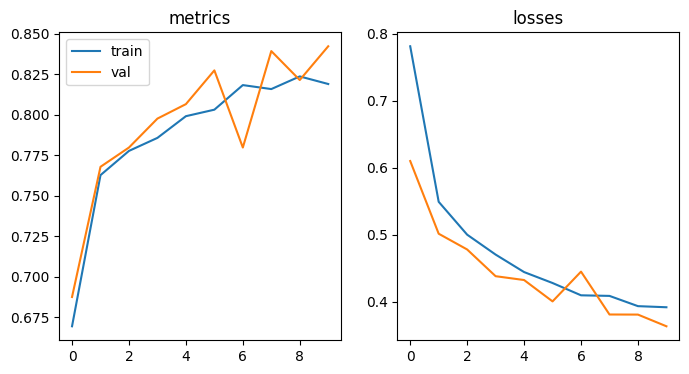

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(history_0.history["accuracy"],label="train")
axs[0].plot(history_0.history["val_accuracy"],label="val")
axs[0].set_title("metrics")

axs[1].plot(history_0.history["loss"])
axs[1].plot(history_0.history["val_loss"])
axs[1].set_title("losses")
axs[0].legend()
plt.show()

Verificamos el rendimiento en el conjunto de prueba

In [ ]:
predictions = model_0.predict(features_test)
print(sklearn.metrics.classification_report(
    label_test.argmax(axis=1), # Utilizamos argmax para obtener la etiqueta de cada punto de datos
    predictions.argmax(axis=1)
))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
              precision    recall  f1-score   support

           0       0.66      0.89      0.76       267
           1       0.83      0.55      0.66       292
           2       0.92      0.93      0.93       297
           3       0.99      0.99      0.99       264

    accuracy                           0.84      1120
   macro avg       0.85      0.84      0.83      1120
weighted avg       0.85      0.84      0.83      1120



¿Cómo se ve el cálculo matemático?

>  FC = $ReLU(X · 𝐖_{fc} + B_{fc})$

<img  src="https://jalammar.github.io/images/NNs_2_variables.png" width="500" height="300"></img>

<img  src="https://jalammar.github.io/images/NNs_formula_two_variables.png" width="500" height="150"></img>





> Prediction = $Softmax(FC · 𝐖_{o} + B_{o})$



In [ ]:
prediction = tf.nn.softmax(
  tf.tensordot(
    tf.nn.relu(
      tf.tensordot(
        features_test.astype(np.float32), #Valores de test
        model_0.layers[0].get_weights()[0], #Producto punto con pesos
        axes=1
      )  + model_0.layers[0].get_weights()[1] #Añadir Bias
    ),                                    #Función de activación Relu
    model_0.layers[1].get_weights()[0],     #Producto punto con pesos capa final
    1
  ) + model_0.layers[1].get_weights()[1]    #Añadir Bias capa Final
)                                         #Softmax
prediction

<tf.Tensor: shape=(1120, 4), dtype=float32, numpy=
array([[4.1070783e-01, 2.9754728e-01, 2.9171625e-01, 2.8642589e-05],
       [1.4438923e-01, 8.4026271e-01, 1.0409041e-02, 4.9390933e-03],
       [3.4433771e-05, 3.5772217e-05, 5.1974500e-09, 9.9992979e-01],
       ...,
       [5.7787788e-01, 4.1396230e-01, 6.9410950e-03, 1.2186939e-03],
       [3.5146343e-06, 2.2204342e-05, 3.4563837e-07, 9.9997389e-01],
       [2.6151878e-01, 6.7280352e-01, 6.4375348e-02, 1.3023588e-03]],
      dtype=float32)>

In [ ]:
prediction_pos = np.argmax(prediction, axis=1)
comparison = np.equal(prediction_pos,label_test.argmax(axis=1))
print(f"Comparación con test:  {comparison} \n")
print(f"Resultados correctamente clasificados {np.sum(comparison)} de un total de {label_test.shape[0]}")

Comparación con test:  [ True  True  True ...  True  True  True] 

Resultados correctamente clasificados 937 de un total de 1120


### Actividad 1

Aumenta la cantidad de épocas y describe cómo se comportan las métricas al aumentar la cantidad de épocas.

In [ ]:
model = tf.keras.Sequential([ # Este objeto recibe una lista de capas.
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa de 128 neuronas con una activación ReLU
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax') # Capa densa de clasificación
                                                                       # con una activación Softmax
                                                                       # la cantidad de neuronas de esta capa
                                                                       # debe ser igual a la cantidad de clases
])
model.compile(optimizer='adam', # Utilizamos un optimizador ADAM
              loss='categorical_crossentropy', # Usamos entropía cruzada categórica porque nuestro problema es de clasificación de más de 2 clases
              metrics=['accuracy']) # Medimos el rendimiento del modelo con la exactitud
history = model.fit( # Guardamos el historial del modelo
          features_scaled,
          label_encoded,
          epochs=30, # Detenemos el entrenamiento al llegar a 10 épocas
          validation_data=(features_val,label_val) # Al final de cada época probamos el rendimiento en el conjunto de validación
          )

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5905 - loss: 0.9541 - val_accuracy: 0.7679 - val_loss: 0.5604
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7287 - loss: 0.5936 - val_accuracy: 0.8095 - val_loss: 0.4828
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7771 - loss: 0.5000 - val_accuracy: 0.8244 - val_loss: 0.4459
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7895 - loss: 0.4657 - val_accuracy: 0.7827 - val_loss: 0.4480
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7943 - loss: 0.4498 - val_accuracy: 0.8274 - val_loss: 0.4259
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8055 - loss: 0.4357 - val_accuracy: 0.8304 - val_loss: 0.4159
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7975 - loss: 0.4292 - val_accuracy: 0.8214 - val_loss: 0.3924
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8232 - loss: 0.3919 - val_accuracy: 0.

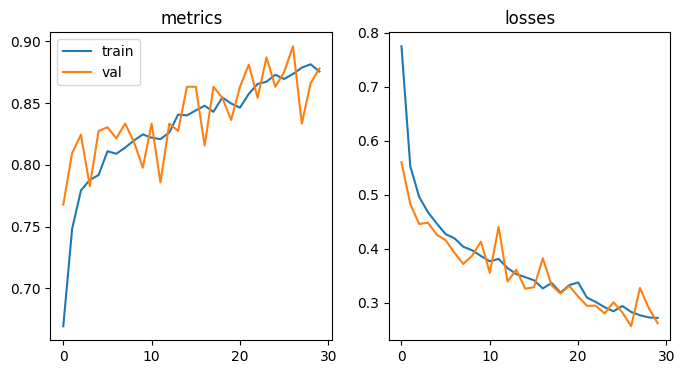

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(history.history["accuracy"],label="train")
axs[0].plot(history.history["val_accuracy"],label="val")
axs[0].set_title("metrics")

axs[1].plot(history.history["loss"])
axs[1].plot(history.history["val_loss"])
axs[1].set_title("losses")
axs[0].legend()
plt.show()

In [ ]:
predictions = model.predict(features_test)
print(sklearn.metrics.classification_report(
    label_test.argmax(axis=1), # Utilizamos argmax para obtener la etiqueta de cada punto de datos
    predictions.argmax(axis=1)
))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       267
           1       0.83      0.77      0.80       292
           2       0.94      0.97      0.96       297
           3       1.00      1.00      1.00       264

    accuracy                           0.89      1120
   macro avg       0.89      0.89      0.89      1120
weighted avg       0.89      0.89      0.89      1120



### Actividad 2

Añada una capa de dimesión 256 al modelo (como primera capa) y compare con la actividad 1

In [ ]:
model = tf.keras.Sequential([ # Este objeto recibe una lista de capas.
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')
])
model.compile(optimizer='adam', # Utilizamos un optimizador ADAM
              loss='categorical_crossentropy', # Usamos entropía cruzada categórica porque nuestro problema es de clasificación de más de 2 clases
              metrics=['accuracy']) # Medimos el rendimiento del modelo con la exactitud
history = model.fit( # Guardamos el historial del modelo
          features_scaled,
          label_encoded,
          epochs=30, # Detenemos el entrenamiento al llegar a 10 épocas
          validation_data=(features_val,label_val) # Al final de cada época probamos el rendimiento en el conjunto de validación
          )

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6047 - loss: 0.9118 - val_accuracy: 0.7708 - val_loss: 0.5465
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7460 - loss: 0.5194 - val_accuracy: 0.7589 - val_loss: 0.4788
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7781 - loss: 0.4726 - val_accuracy: 0.8304 - val_loss: 0.4025
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7980 - loss: 0.4268 - val_accuracy: 0.7887 - val_loss: 0.4169
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7941 - loss: 0.4299 - val_accuracy: 0.8393 - val_loss: 0.3764
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8017 - loss: 0.4322 - val_accuracy: 0.8274 - val_loss: 0.3702
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8254 - loss: 0.3827 - val_accuracy: 0.8512 - val_loss: 0.3228
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8421 - loss: 0.3394 - val_accuracy: 0.

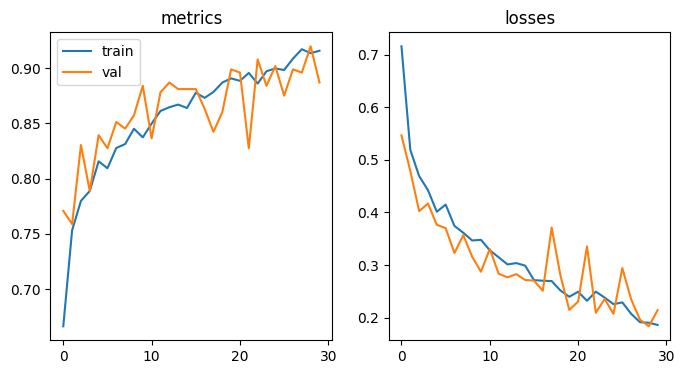

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(history.history["accuracy"],label="train")
axs[0].plot(history.history["val_accuracy"],label="val")
axs[0].set_title("metrics")

axs[1].plot(history.history["loss"])
axs[1].plot(history.history["val_loss"])
axs[1].set_title("losses")
axs[0].legend()
plt.show()

In [ ]:
predictions = model.predict(features_test)
print(sklearn.metrics.classification_report(
    label_test.argmax(axis=1), # Utilizamos argmax para obtener la etiqueta de cada punto de datos
    predictions.argmax(axis=1)
))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
              precision    recall  f1-score   support

           0       0.71      0.99      0.82       267
           1       0.99      0.61      0.75       292
           2       0.96      0.99      0.98       297
           3       1.00      1.00      1.00       264

    accuracy                           0.89      1120
   macro avg       0.91      0.90      0.89      1120
weighted avg       0.92      0.89      0.89      1120



Referencias:

- [tensorflow.nn](https://www.tensorflow.org/api_docs/python/tf/nn)

- [Modelo de keras](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

- [Capas de keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights)

## Red convolucional

Exploraremos cómo se realizan las transformaciones de los datos al transitar por una red convolucional.

In [ ]:
def nice_image_printer(model, image):
    """prints the cat as a 2d array"""
    image_batch = np.expand_dims(image,axis=0)
    conv_image2 = model.predict(image_batch)

    conv_image2 = np.squeeze(conv_image2, axis=0)
    conv_image2 = conv_image2.reshape(conv_image2.shape[:2])

    plt.imshow(conv_image2 , cmap="copper")
    plt.colorbar()

def gkern(kernlen=[21,21], nsig=[3, 3]):
    """Returns a 2D Gaussian kernel array."""

    assert len(nsig) == 2
    assert len(kernlen) == 2
    kern1d = []
    for i in range(2):
        interval = (2*nsig[i]+1.)/(kernlen[i])
        x = np.linspace(-nsig[i]-interval/2., nsig[i]+interval/2., kernlen[i]+1)
        kern1d.append(np.diff(scipy.stats.norm.cdf(x)))

    kernel_raw = np.sqrt(np.outer(kern1d[0], kern1d[1]))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def kernel_init(shape, dtype=None, partition_info=None):
    """Kernel initializer"""
    kernel = np.zeros(shape)
    kernel[:,:,0,0] = gkern([shape[0], shape[1]])
    return kernel

Cargamos y preprocesamos nuestro conjunto de datos.

In [ ]:
!wget -q https://raw.githubusercontent.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/refs/heads/main/data/cat.png

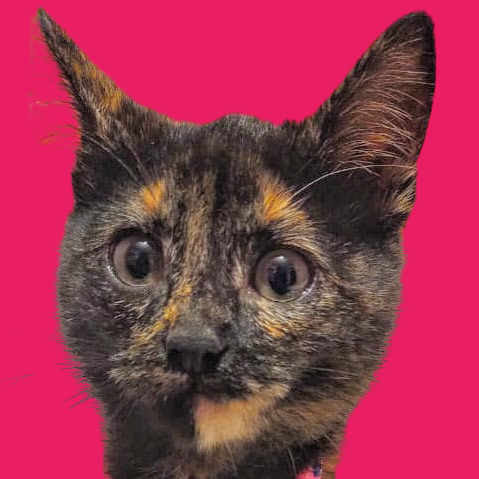

In [ ]:
cat = tf.keras.preprocessing.image.load_img("cat.png") # Importamos la imagen
cat # Visualizamos la imagen

In [ ]:
cat_array = tf.keras.preprocessing.image.img_to_array(cat) / 255 # Transformamos la imagen en un arreglo y lo normalizamos entre 0 y 1.
cat_array.shape # Estas son las dimensiones de nuestra imagen (largo, ancho, canales)

(479, 479, 3)

Instanciamos nuestro primer modelo con una capa única de convolución.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


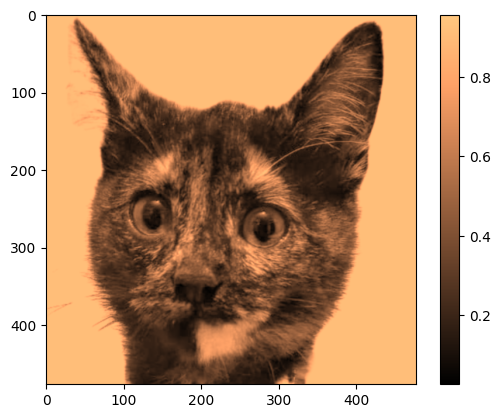

In [ ]:
cat_model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D( # Capa convolucional
      filters = 1, # Sólo utilizaremos 1 kernel
      kernel_size = (3,3), # Estas son las dimensiones del kernel
      input_shape = cat_array.shape, # Estas son las dimensiones de entrada de la red.
      kernel_initializer = kernel_init((3,3,3,1)) # Utilizamos un kernel gausiano que lo generamos con nuestro inicializador
  )
])
nice_image_printer(cat_model_1, cat_array)

Aumentamos el tamaño del kernel.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step


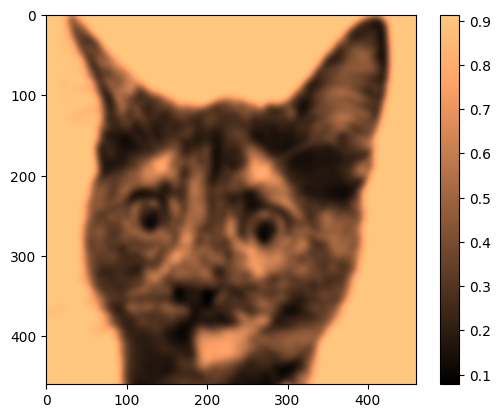

In [ ]:
cat_model_2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (20,20), # Ahora el kernel es de 15*15
      input_shape = cat_array.shape,
      kernel_initializer = kernel_init
  )
])
nice_image_printer(cat_model_2, cat_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


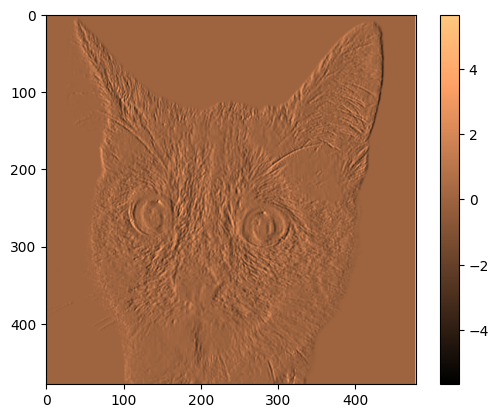

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


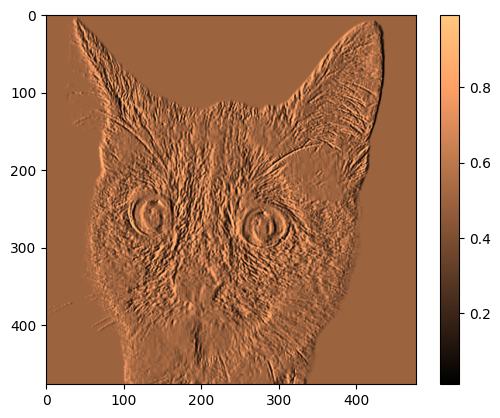

In [ ]:
# Filtro Sobel 3x3
kernel = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
], dtype=np.float32)

# Expande a 3 canales (RGB, por ejemplo), y a 1 filtro de salida
kernel = np.stack([kernel, kernel, kernel], axis=-1)  # (3, 3, 3)
kernel = np.expand_dims(kernel, axis=-1)              # (3, 3, 3, 1)

input_shape = cat_array.shape  # (alto, ancho, canales)

cat_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(3, 3),
        input_shape=input_shape,
        padding='same',
        use_bias=False,
        kernel_initializer = kernel_init
    )
])
# Se asignan los pesos a la capa
cat_model_3.set_weights([kernel])

cat_model_4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = input_shape,
      activation = "sigmoid",
      use_bias=False,
      kernel_initializer = kernel_init
  ),
])
# Se asignan los pesos a la capa
cat_model_4.set_weights([kernel])

nice_image_printer(cat_model_3, cat_array)
plt.show()
nice_image_printer(cat_model_4, cat_array)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


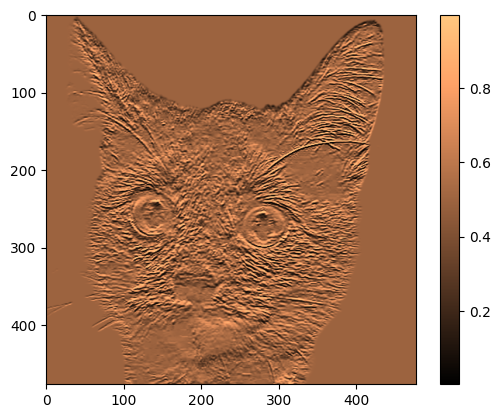

In [ ]:
#Cambiar pesos del kernel
kernel = np.array(
    [
     [-1,-2,-1],
     [0,0,0],
     [1,2,1]
    ])
kernel = np.expand_dims(np.stack([kernel,kernel,kernel],axis=-1), axis=-1)

cat_model_5 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      activation = "sigmoid",
      kernel_initializer = kernel_init,
      use_bias=False
  ),
])

cat_model_5.layers[0].set_weights([kernel])
nice_image_printer(cat_model_5, cat_array)

Agregamos una función de activación y max pooling.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


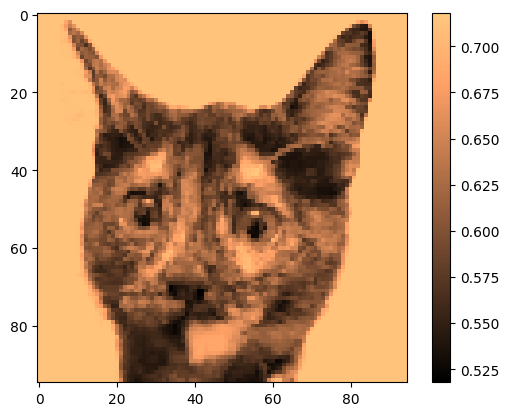

In [ ]:
cat_model_6 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      activation = "sigmoid",
      kernel_initializer = kernel_init
  ),
  tf.keras.layers.MaxPool2D(
      pool_size = (5,5)
  )
])

nice_image_printer(cat_model_6, cat_array)

### Actividad 3

Cree un kernel que destaque todos los bordes (arriba, abajo, izquierda y derecha) y reduzca la dimensión de la imágen en una 3ra parte utilizando Maxpooling. Utilize la función de activación `sigmoid` para comparar con los resultados anteriores.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


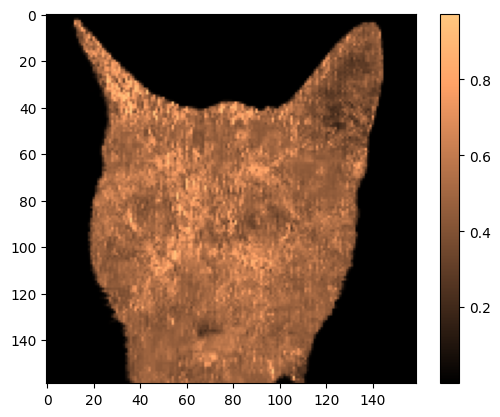

In [ ]:
#Cambiar pesos del kernel
kernel = np.array(
    [
     [-1,-1,-1],
     [-1,8,-1],
     [-1,-1,-1]
    ])
kernel = np.expand_dims(np.stack([kernel,kernel,kernel]), axis=-1)
weights = [kernel,np.array([0])]

cat_model_7 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      activation = "sigmoid",
      kernel_initializer = kernel_init
  ),
  tf.keras.layers.MaxPool2D(
      pool_size = (3,3)
  )

])

cat_model_7.layers[0].set_weights(weights)
nice_image_printer(cat_model_7, cat_array)

## Clasificación de radiografías de tórax

Para este notebook se utilizaron los datos de https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 y código de https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia

In [ ]:
# Obtenemos el conjunto de datos desde el servidor de SASIBA.
!gdown 1JXOpOKfnItGOIc_Ua-NqScIGjwAlcql- -O chest_xray.rar

Downloading...
From (original): https://drive.google.com/uc?id=1JXOpOKfnItGOIc_Ua-NqScIGjwAlcql-
From (redirected): https://drive.google.com/uc?id=1JXOpOKfnItGOIc_Ua-NqScIGjwAlcql-&confirm=t&uuid=512e2203-61bc-440e-b30b-d266a7d53d9a
To: /content/chest_xray.rar
100% 1.13G/1.13G [00:17<00:00, 66.0MB/s]


In [ ]:
# Descomprimimos el conjunto de datos.
!unrar x chest_xray.rar -idq

In [ ]:
# Configuramos las rutas de los datos
train_folder= 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

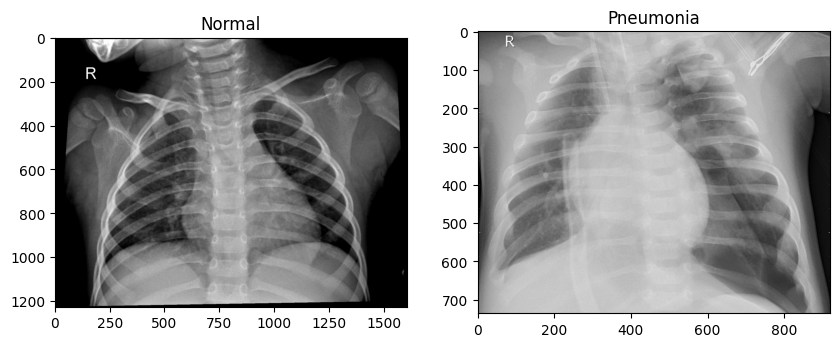

In [ ]:
# Miramos un par de radiografías normales y patólogicas al azar

rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]

norm_pic_address = train_n+norm_pic

rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic

norm_load = PIL.Image.open(norm_pic_address)
sic_load = PIL.Image.open(sic_address)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap="gray")
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap="gray")
a2.set_title('Pneumonia')

plt.show()

In [ ]:
# Configuramos el generador de datos que utilizará nuestra red

batch_size = 32

# Queremos aumentar los datos del conjunto de prueba al generar imágenes sintéticas distorisionadas
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, # A las imágenes se les normaliza el brillo
                                   #shear_range = 0.2, # Distorsionamos las imágenes
                                   #zoom_range = 0.2, # Acercamos las imágenes
                                   #horizontal_flip = True
                                   ) # Volteamos horizontalmente las imágenes

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64), # Las imágenes se redimensionan a 64*64
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 color_mode="grayscale") # Sólo utilizamos el canal de brillo

val_set = test_datagen.flow_from_directory(val_folder,
                                            target_size=(64, 64),
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle = False,
                                            color_mode="grayscale")

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            shuffle = False,
                                            color_mode="grayscale")

Found 4186 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Construimos la arquitectura de la red neuronal

cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1))) # Capa de convolución

cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))

cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(activation = 'relu', units = 128))
cnn.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Creamos la arquitectura

In [ ]:
# Verificamos la arquitectura

cnn.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,641 (3.10 MB)

 Trainable params: 812,641 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenamos la red neuronal
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

cnn_history = cnn.fit(training_set,
                         epochs = 10, # Entrenamos la red por 10 épocas
                         validation_data = val_set,
                        callbacks=callback)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 219ms/step - accuracy: 0.8259 - loss: 0.3916 - val_accuracy: 0.6875 - val_loss: 0.7215
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 209ms/step - accuracy: 0.9566 - loss: 0.1122 - val_accuracy: 0.9375 - val_loss: 0.2299
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 205ms/step - accuracy: 0.9663 - loss: 0.0956 - val_accuracy: 0.9375 - val_loss: 0.2285
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.9678 - loss: 0.0846 - val_accuracy: 0.8750 - val_loss: 0.3090
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.9766 - loss: 0.0746 - val_accuracy: 0.8125 - val_loss: 0.3868
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 199ms/step - accuracy: 0.9720 - loss: 0.0684 - val_accuracy: 0.9375 - val_loss: 0.2096
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.9839 - loss: 0.0483 - val_accuracy: 0.9375 - val_loss: 0.2102
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.9850 - loss: 0

In [ ]:
predictions = cnn.predict(test_set, verbose = 1) > 0.5 # Predecimos sobre el conjunto de prueba

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step


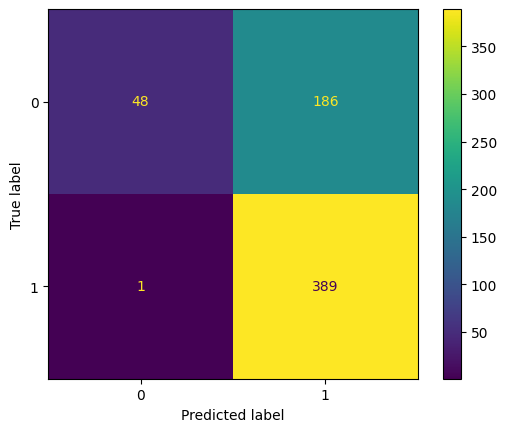

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_set.classes, predictions)
plt.show()

In [ ]:
print(sklearn.metrics.classification_report(test_set.classes, predictions)) # Resumen del rendimiento del modelo

              precision    recall  f1-score   support

           0       0.98      0.21      0.34       234
           1       0.68      1.00      0.81       390

    accuracy                           0.70       624
   macro avg       0.83      0.60      0.57       624
weighted avg       0.79      0.70      0.63       624



### Exploración

Para entender cómo funciona la red neuronal, visualizaremos las salidas de cada una de las capas.

In [ ]:
def image_loader(path):
  image_location = path # Seleccionamos una imagen del conjunto de prueba
  img = PIL.Image.open(image_location)
  # Cargamos la imagen
  img_resized = tf.keras.preprocessing.image.load_img(
      image_location,
      target_size = (64, 64), # Debemos redimensionar la imagen para poder ser ingresada a la red
      color_mode="grayscale"
  )
  # Transformamos la imagen en un arreglo de las dimensiones que recibe la red
  img_array = tf.keras.preprocessing.image.img_to_array(
      img_resized
  )
  img_array = np.expand_dims(
      img_array,
      axis=0
  )
  return img, img_resized, img_array

def get_activations(model,img_array):
  # Creamos un modelo que entrega los resultados después de cada capa
  layer_outputs = [layer.output for layer in model.layers]
  layer_names = [layer.name for layer in model.layers]
  activation_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=layer_outputs)
  activations = activation_model.predict(img_array)
  activations = list(zip(layer_names,activations))
  return activations

# Esta función grafica los resultados de los filtros de la capa de convolución
def plot_conv_layer_result(activations,j):
  fig, axs = plt.subplots(
      nrows=4,
      ncols=8,
      figsize=(15,8)
  )
  fig.suptitle(activations[j][0])
  for i,ax in enumerate(axs.ravel()):
      ax.imshow(activations[j][1][0,:,:,i], cmap="viridis")
      ax.axis("off")
  plt.show()

# Con esto graficamos los arreglos unidimensionales
def plot_1d_layer_result(activations,j):
  values = activations[j][1][0,:]
  plt.bar(
      range(len(values)),
      values
  )
  plt.title(activations[j][0])
  plt.show()

#### Radiografía de pneumonia

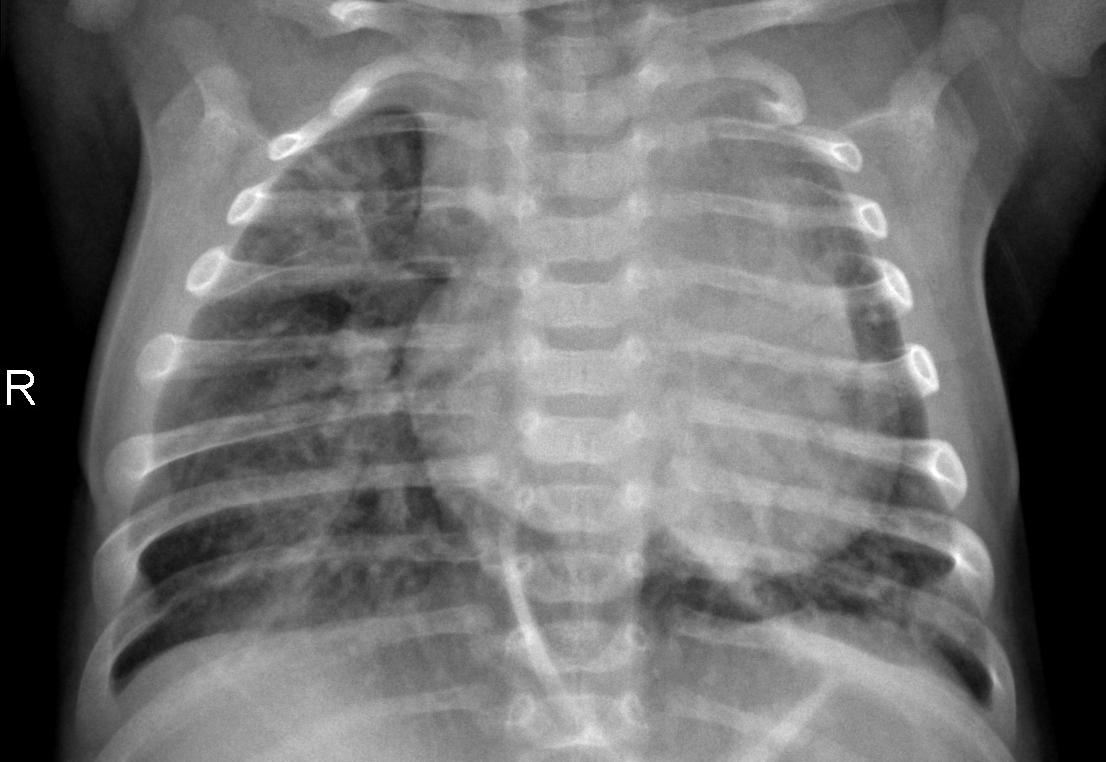

In [ ]:
pneumonia_img, pneumonia_img_resized, pneumonia_img_array = image_loader("chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")
pneumonia_img

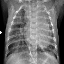

In [ ]:
pneumonia_img_resized

In [ ]:
# Predecimos sobre el arreglo
pneumonia_activations = get_activations(cnn,pneumonia_img_array)
cnn.predict(pneumonia_img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


array([[1.]], dtype=float32)

En el siguiente gráfico vemos las 32 imágenes correspondientes a la salida de cada uno de los filtros de la capa de convolución.

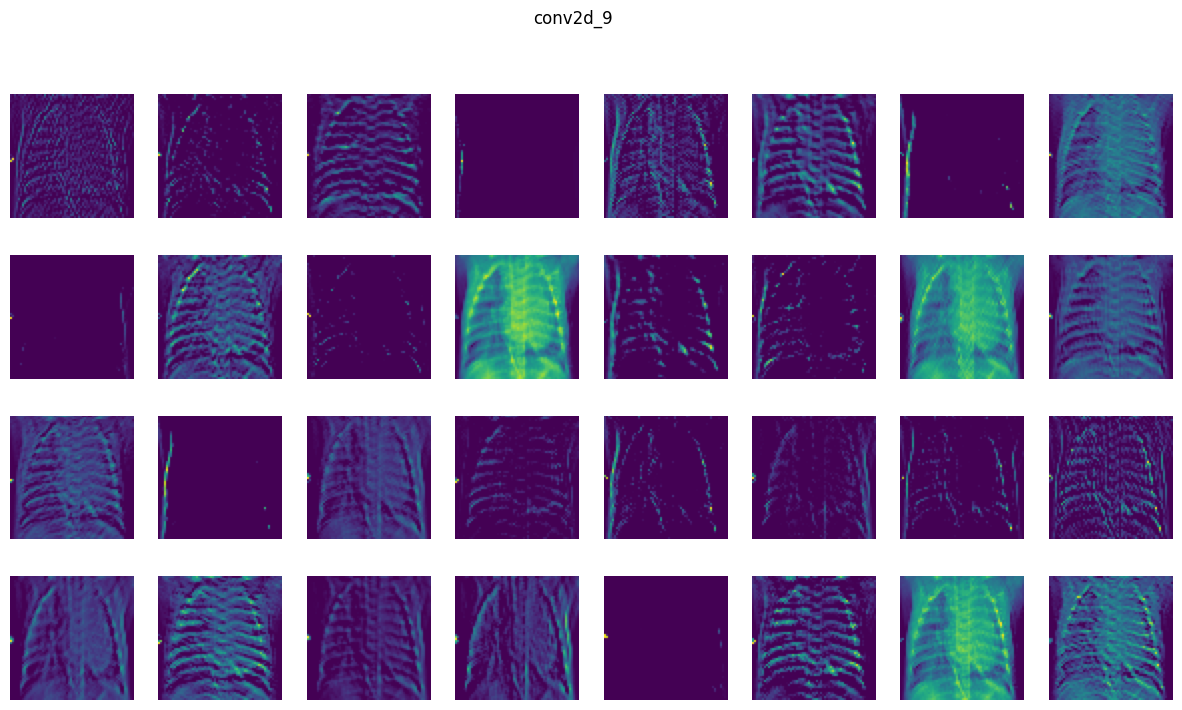

In [ ]:
plot_conv_layer_result(pneumonia_activations,0)

Vemos que sucede en la segúnda capa de covolución




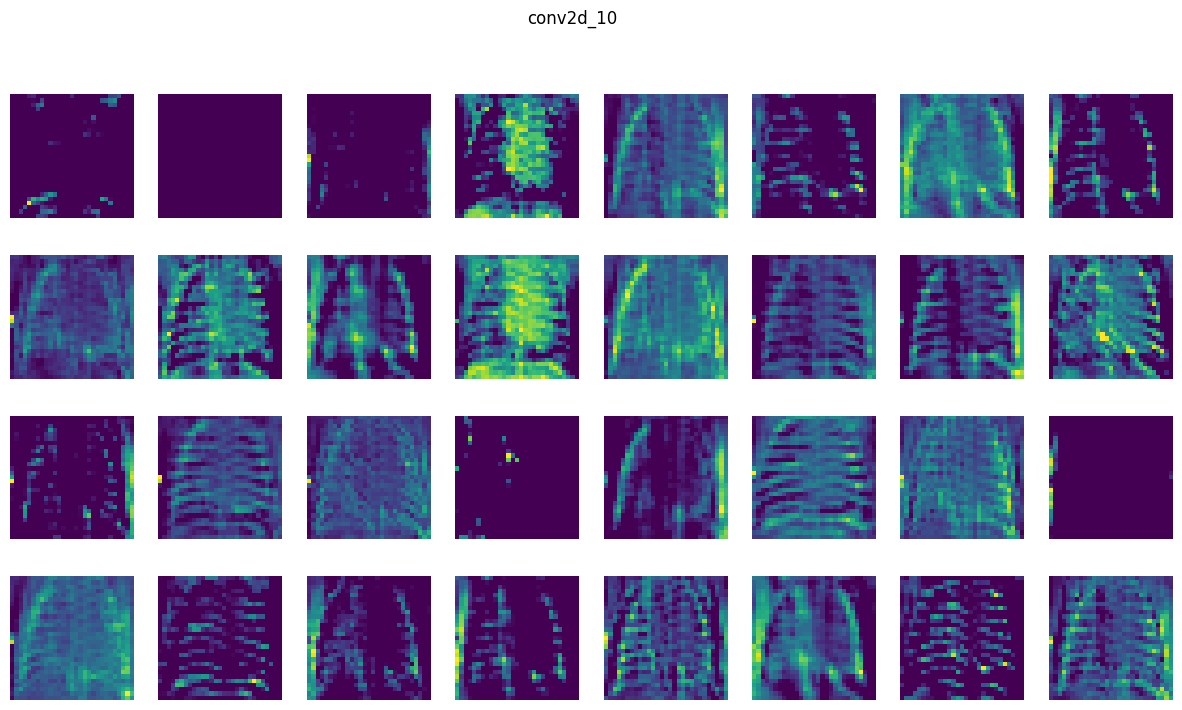

In [ ]:
plot_conv_layer_result(pneumonia_activations,2)

### Actividad 4

Modifica la arquitectura agregando una nueva capa de convolución y max-pooling prueba, si mejoran las métricas y visualiza las salidas de las capas.

In [ ]:
# Construimos la arquitectura de la red neuronal

cnn_2 = tf.keras.Sequential()

cnn_2.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1))) # Capa de convolución

cnn_2.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn_2.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))

cnn_2.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn_2.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))

cnn_2.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn_2.add(tf.keras.layers.Flatten())

cnn_2.add(tf.keras.layers.Dense(activation = 'relu', units = 128))
cnn_2.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

cnn_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Creamos la arquitectura

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Entrenamos la red neuronal

cnn_2_history = cnn_2.fit(training_set,
                         epochs = 10, # Entrenamos la red por 10 épocas
                         validation_data = val_set,
                          callbacks = callback)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.9574 - loss: 0.0950 - val_accuracy: 0.6875 - val_loss: 0.5672
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 214ms/step - accuracy: 0.9649 - loss: 0.0825 - val_accuracy: 0.8750 - val_loss: 0.2337
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.9691 - loss: 0.0821 - val_accuracy: 0.6875 - val_loss: 0.8260
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 203ms/step - accuracy: 0.9651 - loss: 0.0924 - val_accuracy: 1.0000 - val_loss: 0.1745
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.9732 - loss: 0.0720 - val_accuracy: 0.9375 - val_loss: 0.1570
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 205ms/step - accuracy: 0.9748 - loss: 0.0695 - val_accuracy: 0.8125 - val_loss: 0.3193
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.9795 - loss: 0.0548 - val_accuracy: 0.9375 - val_loss: 0.1624
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.9850 - loss: 0

In [ ]:
predictions_2 = cnn_2.predict(test_set, verbose = 1) > 0.5 # Predecimos sobre el conjunto de prueba

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step


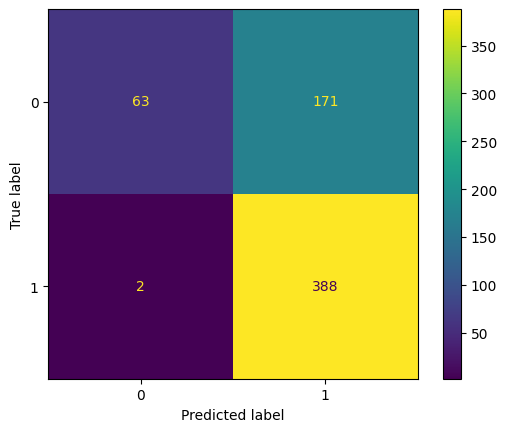

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_set.classes, predictions_2)
plt.show()

In [ ]:
print(sklearn.metrics.classification_report(test_set.classes, predictions_2)) # Resumen del rendimiento del modelo

              precision    recall  f1-score   support

           0       0.97      0.27      0.42       234
           1       0.69      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.83      0.63      0.62       624
weighted avg       0.80      0.72      0.67       624

